In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    classification_report,
    confusion_matrix,
    roc_auc_score,
    average_precision_score,
    roc_curve,
    precision_recall_curve
)

from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as ImbPipeline

from xgboost import XGBClassifier
import joblib

sns.set(style="whitegrid")


In [2]:
df = pd.read_csv("../data/creditcard_preprocessed.csv")
df.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V23,V24,V25,V26,V27,V28,Amount,Class,Amount_log,Hour
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0,5.014760,0.0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0,1.305626,0.0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0,5.939276,0.0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0,4.824306,0.0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0,4.262539,0.0


In [3]:
X = df.drop(columns=["Class"])
y = df["Class"]

X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    random_state=42,
    stratify=y
)

print("Train size:", X_train.shape, " Test size:", X_test.shape)
print("Fraud ratio train:", y_train.mean())
print("Fraud ratio test:", y_test.mean())


Train size: (227845, 32)  Test size: (56962, 32)
Fraud ratio train: 0.001729245759178389
Fraud ratio test: 0.0017204452090867595


In [4]:
n_pos = y_train.sum()
n_neg = len(y_train) - n_pos
scale_pos_weight = n_neg / n_pos

scale_pos_weight


np.float64(577.2868020304569)

In [5]:
smote = SMOTE(random_state=42)

xgb_clf = XGBClassifier(
    n_estimators=300,
    max_depth=5,
    learning_rate=0.05,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42,
    n_jobs=-1,
    eval_metric="logloss",
    scale_pos_weight=scale_pos_weight  
)

pipeline_xgb = ImbPipeline(steps=[
    ("smote", smote),
    ("clf", xgb_clf)
])

pipeline_xgb


,steps,"[('smote', ...), ('clf', ...)]"
,transform_input,None
,memory,None
,verbose,False
,sampling_strategy,'auto'
,random_state,42
,k_neighbors,5
,objective,'binary:logistic'
,base_score,None
,booster,None
,callbacks,None


In [6]:
pipeline_xgb.fit(X_train, y_train)
print("Model trained!")


Model trained!


In [7]:
y_pred = pipeline_xgb.predict(X_test)
y_proba = pipeline_xgb.predict_proba(X_test)[:, 1]

print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))

print("\nClassification Report:")
print(classification_report(y_test, y_pred, digits=4))

roc_auc = roc_auc_score(y_test, y_proba)
pr_auc = average_precision_score(y_test, y_proba)

print("ROC-AUC:", roc_auc)
print("PR-AUC:", pr_auc)


Confusion Matrix:
[[56298   566]
 [   10    88]]

Classification Report:
              precision    recall  f1-score   support

           0     0.9998    0.9900    0.9949     56864
           1     0.1346    0.8980    0.2340        98

    accuracy                         0.9899     56962
   macro avg     0.5672    0.9440    0.6145     56962
weighted avg     0.9983    0.9899    0.9936     56962

ROC-AUC: 0.9861717143948182
PR-AUC: 0.8424217948964586


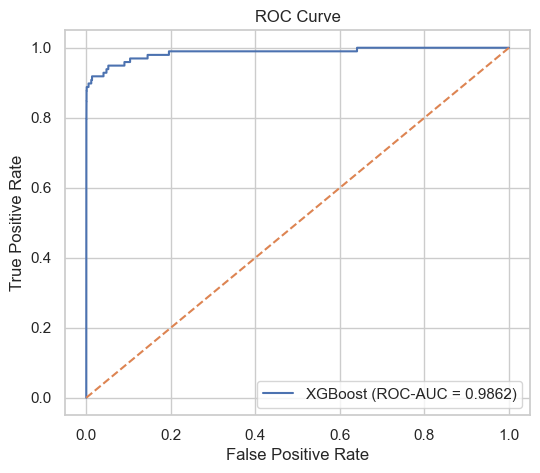

In [8]:
fpr, tpr, thresholds = roc_curve(y_test, y_proba)

plt.figure(figsize=(6,5))
plt.plot(fpr, tpr, label=f"XGBoost (ROC-AUC = {roc_auc:.4f})")
plt.plot([0, 1], [0, 1], linestyle="--")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend()
plt.show()


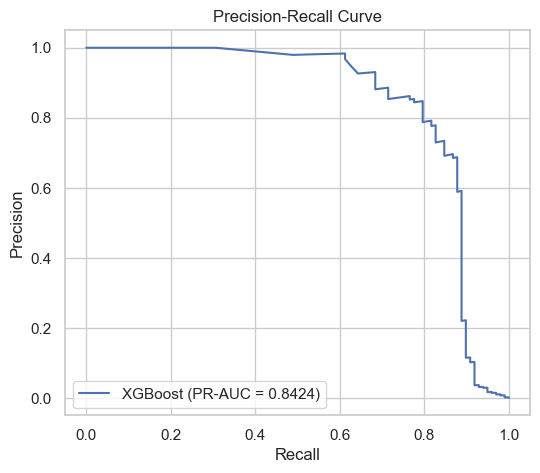

In [9]:
precision, recall, thresholds = precision_recall_curve(y_test, y_proba)

plt.figure(figsize=(6,5))
plt.plot(recall, precision, label=f"XGBoost (PR-AUC = {pr_auc:.4f})")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curve")
plt.legend()
plt.show()


In [10]:
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint, uniform

# Hyperparameter tuning for XGBoost with RandomizedSearchCV
param_distributions = {
    "clf__n_estimators": randint(200, 500),
    "clf__max_depth": randint(3, 8),
    "clf__learning_rate": uniform(0.01, 0.1),
    "clf__subsample": uniform(0.6, 0.4),
    "clf__colsample_bytree": uniform(0.6, 0.4)
}

random_search = RandomizedSearchCV(
    estimator=pipeline_xgb,
    param_distributions=param_distributions,
    n_iter=20,
    scoring="average_precision",  # PR-AUC
    cv=3,
    verbose=1,
    n_jobs=-1,
    random_state=42
)

random_search.fit(X_train, y_train)


Fitting 3 folds for each of 20 candidates, totalling 60 fits


,estimator,"Pipeline(step...=None, ...))])"
,param_distributions,"{'clf__colsample_bytree': <scipy.stats....002055217F750>, 'clf__learning_rate': <scipy.stats....0020551008C20>, 'clf__max_depth': <scipy.stats....00205521547D0>, 'clf__n_estimators': <scipy.stats....00205510081A0>, ...}"
,n_iter,20
,scoring,'average_precision'
,n_jobs,-1
,refit,True
,cv,3
,verbose,1
,pre_dispatch,'2*n_jobs'
,random_state,42
,error_score,nan


In [ ]:
# Results of RandomizedSearchCV
print("Best params:", random_search.best_params_)
print("Best CV PR-AUC:", random_search.best_score_)

best_xgb_pipeline = random_search.best_estimator_

y_pred_best = best_xgb_pipeline.predict(X_test)
y_proba_best = best_xgb_pipeline.predict_proba(X_test)[:, 1]

print("Confusion Matrix (best model):")
print(confusion_matrix(y_test, y_pred_best))

print("\nClassification Report (best model):")
print(classification_report(y_test, y_pred_best, digits=4))

roc_auc_best = roc_auc_score(y_test, y_proba_best)
pr_auc_best = average_precision_score(y_test, y_proba_best)

print("ROC-AUC (best):", roc_auc_best)
print("PR-AUC (best):", pr_auc_best)


Best params: {'clf__colsample_bytree': np.float64(0.6571467271687763), 'clf__learning_rate': np.float64(0.07508884729488528), 'clf__max_depth': 7, 'clf__n_estimators': 457, 'clf__subsample': np.float64(0.8887995089067299)}
Best CV PR-AUC: 0.8397493359129186
Confusion Matrix (best model):
[[56832    32]
 [   12    86]]

Classification Report (best model):
              precision    recall  f1-score   support

           0     0.9998    0.9994    0.9996     56864
           1     0.7288    0.8776    0.7963        98

    accuracy                         0.9992     56962
   macro avg     0.8643    0.9385    0.8980     56962
weighted avg     0.9993    0.9992    0.9993     56962

ROC-AUC (best): 0.9842003979419568
PR-AUC (best): 0.8821009414159884
